<a href="https://colab.research.google.com/github/alice-malivert/Tutorial_transformers/blob/main/Transformers_tutorial_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers for image segmentation


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Oct 22 14:25:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Task and dataset
Segmentating an image means to partition it into different components, based on the objects/parts that make it up. It is a field for which ML makes an incredible difference, for example in biology.

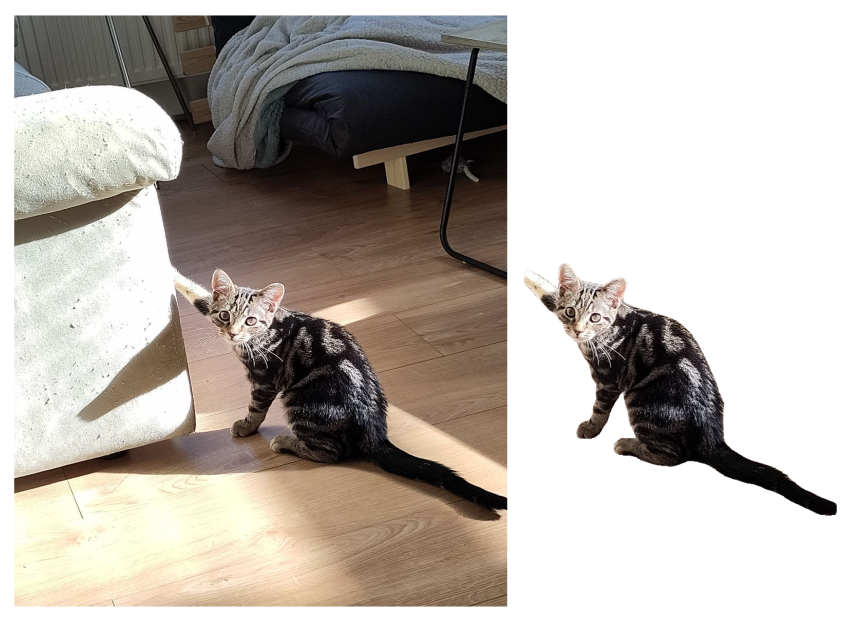

In [ ]:
# Load a dataset of images

from google.colab import drive
drive.mount('/content/drive/')
import os
dataset_folder = '/content/drive/My Drive/Mousse/'
list_images = os.listdir(dataset_folder)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install -U -q PyDrive

In [ ]:
# Import necessary libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder ID from the shared link
folder_id = '1h03CC3QEgexdnqptSzSdBZhreoPIs5hl'

# List all files in the shared folder
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
for file in file_list:
    print(f"File: {file['title']}, ID: {file['id']}")

# Example: Download a specific file by ID
file_id = file_list[0]['id']  # Replace with the actual file ID you want to download
downloaded_file = drive.CreateFile({'id': file_id})
downloaded_file.GetContentFile(downloaded_file['title'])  # Saves the file locally


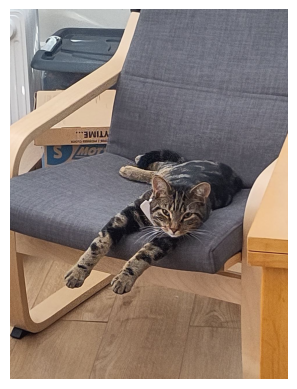

In [ ]:
# Display an image

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
image_path = os.path.join(dataset_folder, list_images[0])
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# The Huggingface transformers library

Huggingface has created a transformers library with different models for several tasks. First, let's install it:

##Set up

In [ ]:
%%capture
!pip install -q datasets transformers evaluate accelerate
!pip install timm

You can see that many tasks you would require transformers for (including several computer vision tasks) are part of this library:

In [ ]:
from transformers import pipelines
for task in pipelines.SUPPORTED_TASKS:
    print(task)

audio-classification
automatic-speech-recognition
text-to-audio
feature-extraction
text-classification
token-classification
question-answering
table-question-answering
visual-question-answering
document-question-answering
fill-mask
summarization
translation
text2text-generation
text-generation
zero-shot-classification
zero-shot-image-classification
zero-shot-audio-classification
image-classification
image-feature-extraction
image-segmentation
image-to-text
object-detection
zero-shot-object-detection
depth-estimation
video-classification
mask-generation
image-to-image


Let's access my hugginface tokens and set up everything

In [ ]:
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
from transformers import pipeline
from PIL import Image
import requests
import timm

## Segmentation functions
I am now building functions to segment everything in my images, classify the objects and return the cat as a mask overlaying the original image.

In [ ]:
def find_masks(image_path):
  """
  Applies an image_segmentation on the image with the path image_path.
  Returns the list of masks found.
  """

  image = Image.open(image_path)
  panoptic_segmentation = pipeline("image-segmentation", "facebook/detr-resnet-50-panoptic")
  results = panoptic_segmentation(image)
  return(results)

In [ ]:
def chose_cat_mask(results):
  """
  Selects the masks labelled as cat and returns them.
  """

  cat_mask = None
  for result in results:
      if result['label'] == 'cat':
          cat_mask = result['mask']
          break
  if cat_mask is not None:
      print("Cat mask found!")
  else:
      print("No cat found in the image.")
  return (cat_mask)

In [ ]:
def plot_cat_mask(cat_mask, image_path):
    """
    Plots the mask from cat_mask as a blue transparent overlay over the image from image_path.
    """

    image = Image.open(image_path)
    mask_array = np.array(cat_mask)
    blue_overlay = np.zeros((mask_array.shape[0], mask_array.shape[1], 4), dtype=np.uint8)
    blue_overlay[:, :, 2] = 255
    blue_overlay[:, :, 3] = mask_array * 128

    blue_overlay_img = Image.fromarray(blue_overlay)
    image_with_overlay = Image.alpha_composite(image.convert("RGBA"), blue_overlay_img)

    # Display the image with overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_overlay)
    plt.axis('off')
    plt.show()

In [ ]:
def batch_images(dataset_folder, indices=None):
    """
    Calculates and plots as overlay the masks of the cat found in each picture of dataset_folder.
    Users can specify which images to process by providing a list of indices.
    """

    list_images = os.listdir(dataset_folder)

    if indices is None:
        indices = range(len(list_images))

    for i in indices:
        image_path = os.path.join(dataset_folder, list_images[i])

        masks = find_masks(image_path)  # Find masks in the image
        cat_mask = chose_cat_mask(masks)  # Choose the mask corresponding to the 'cat'

        if cat_mask:
            plot_cat_mask(cat_mask, image_path)  # Plot the 'cat' mask over the image

##Application

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Cat mask found!


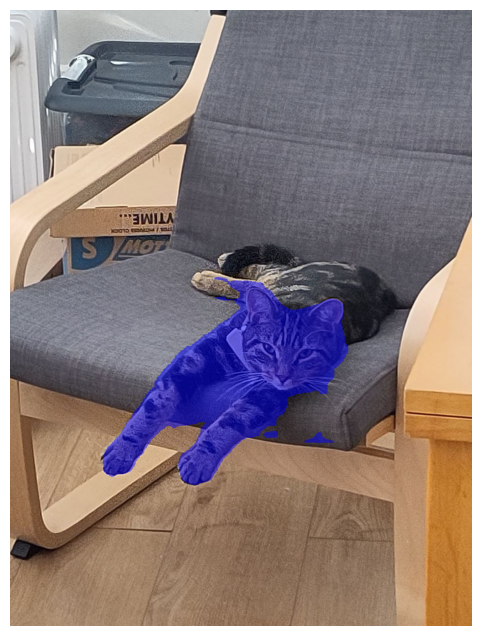

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Cat mask found!


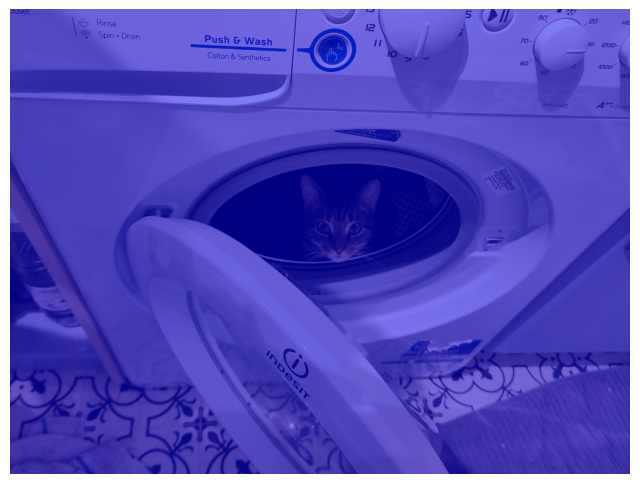

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Cat mask found!


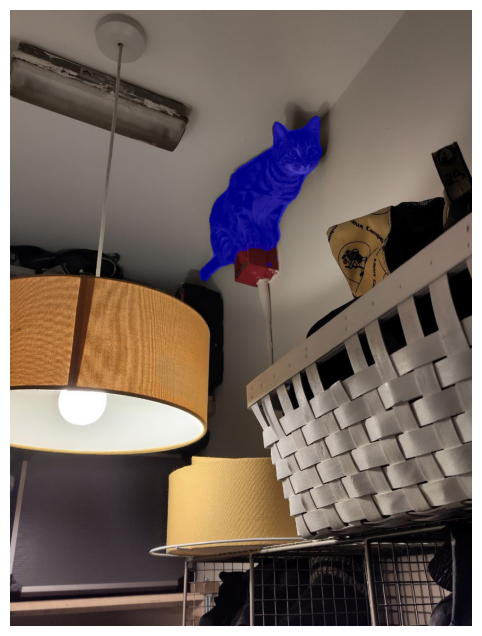

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Cat mask found!


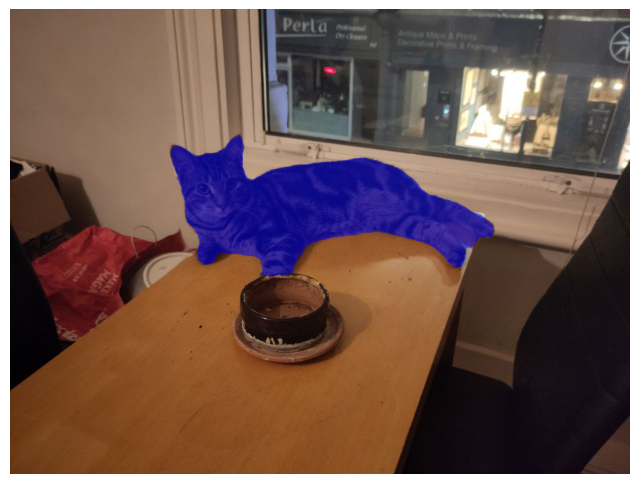

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Cat mask found!


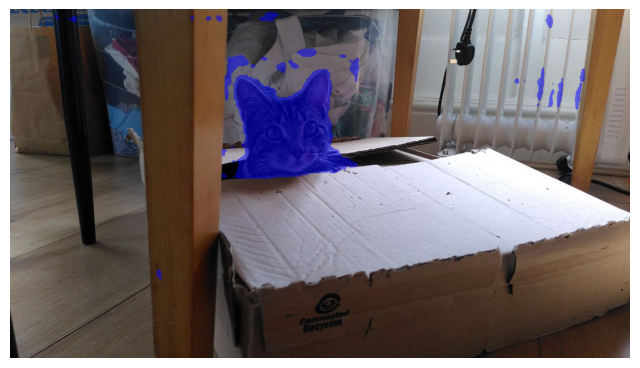

In [ ]:
batch_images(dataset_folder,range(0,5))

We can see that some of the images are well-segmented while others are not. Let's try a more general (foundation?) model.

# The Segment Anything Model

Meta has developped a zero-shot segmentation model, i.e. a model which they argue can be used on any image to segment any object without further training.

First, let's install the model:

In [ ]:
%%capture
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [ ]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Download SAM weights:

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


Load model:

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Automated mask segmentation:

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import cv2
import supervision as sv

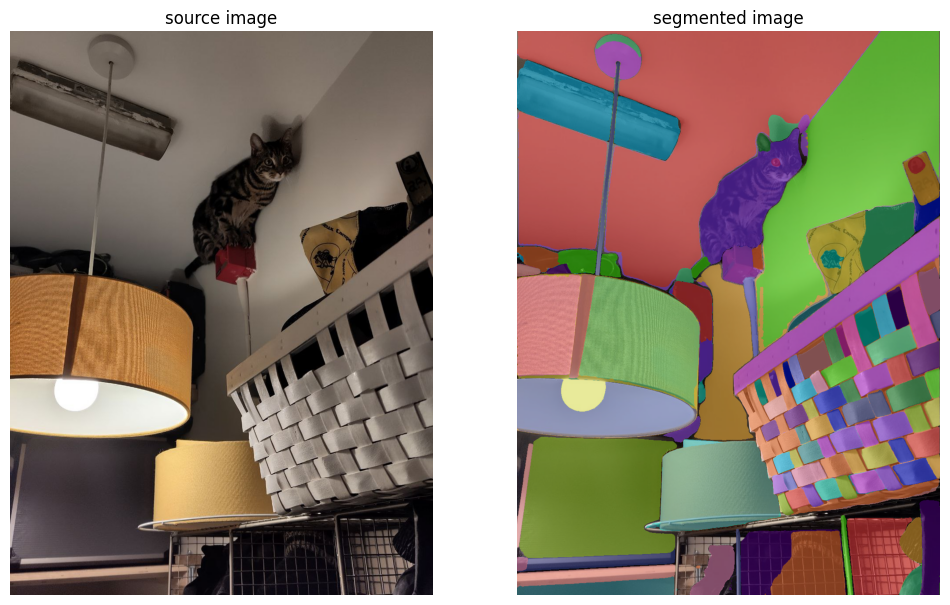

In [ ]:
image_path = os.path.join(dataset_folder, list_images[2])
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
sam_result

[{'segmentation': array([[False, False,  True, ..., False, False, False],
         [False, False,  True, ..., False, False, False],
         [False, False,  True, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 243990,
  'bbox': [0, 0, 820, 580],
  'predicted_iou': 1.022744059562683,
  'point_coords': [[375.0, 220.0]],
  'stability_score': 0.9635697603225708,
  'crop_box': [0, 0, 960, 1280]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 139822,
  'bbox': [0, 551, 413, 370

## To go further
Even if the SAM scores well on fairness for genders and skin tones, the images the SAM has been trained on still reflect a human bias: plant blindness. Crops and land are often considered as background, especially for drone/satellite images, and as such, they are often badly segmented. See https://doi.org/10.48550/arXiv.2304.05750.

Of course, the SAM as any other model can be refined for a specific task. Here is an example of improvement for segmentation from aerial and satellite images, turning the zero-shot model into a one-shot model: https://doi.org/10.1016/j.jag.2023.103540 .